In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import shap



# we want our plots to appear inside the notebook
%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve

In [18]:
df = pd.read_csv("Cleveland_data.csv")
df.shape # (rows, columns)
# df = (df-df.min())/(df.max()-df.min())

(303, 14)

In [3]:
# Are there any missing values?
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [19]:
# Split data into X and y
X = df.drop("target", axis=1)
y = df["target"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)


In [20]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3)

In [27]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    """
    # set random seed
    # np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [33]:
model_scores = fit_and_score(models=models,
                            X_train=X_train,
                            X_test=X_test,
                            y_train=y_train,
                            y_test=y_test)

model_scores

{'Logistic Regression': 0.8131868131868132}

In [34]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [54]:
# Tune LogisticRegression
np.random.seed(42)

# Setup random hypterparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=15,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparamter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


RandomizedSearchCV(cv=15, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [55]:
# Check the best hyperparameters
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.03359818286283781}

In [56]:
# Evaluate the grid search LogisticRegression model
rs_log_reg.score(X_test, y_test)

0.8461538461538461

In [57]:
# Make predictions with tuned model
y_preds = rs_log_reg.predict(X_test)
y_preds

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1], dtype=int64)

In [58]:
# Create a new classifier with best parameters
clf = LogisticRegression(C= 0.03359818286283781,
                         solver="liblinear")

In [59]:
# Cross-validated accuracy
cv_acc = cross_val_score(clf,
                         X,
                         y,
                         cv=10,
                         scoring="accuracy")

cv_acc.max()

0.8709677419354839

In [18]:
import shap
explainer = shap.KernelExplainer(rs_log_reg.predict, shap.kmeans(X_train.values,10))
shap_values = explainer.shap_values(X_test.values)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/61 [00:00<?, ?it/s]

In [19]:
shap.initjs()

In [20]:
shap.force_plot(explainer.expected_value,shap_values,X_test.values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


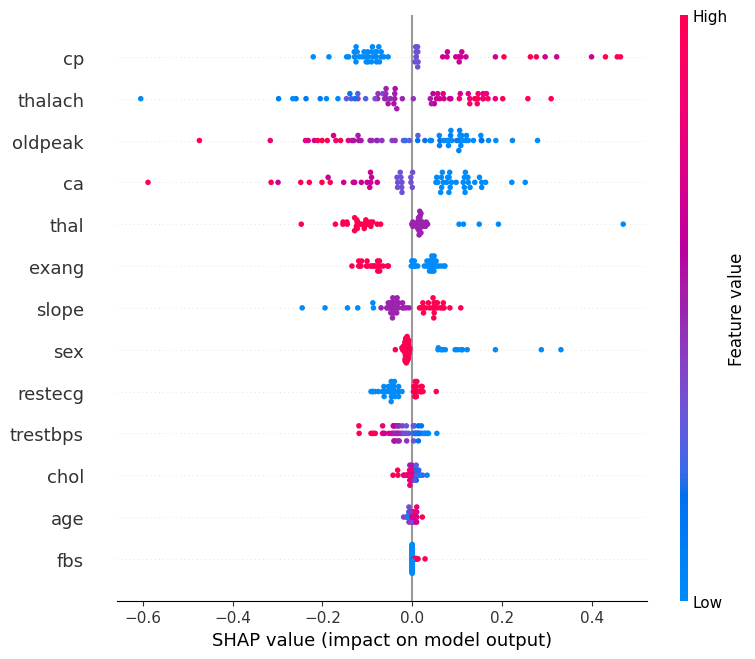

In [21]:
shap.summary_plot(shap_values, X_test)

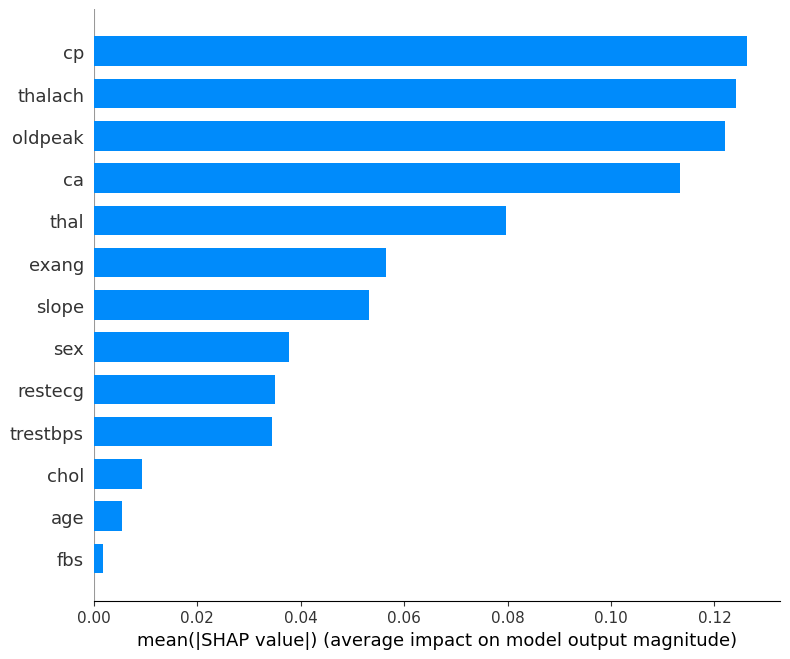

In [22]:
shap.summary_plot(shap_values, X, plot_type="bar")